C:\ProgramData\Anaconda3\envs\B3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\ProgramData\Anaconda3\envs\B3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


using previous tuning parameters
Best OOB Accuracy Estimate during tuning: 0.8467
Best parameters:{'n_estimators': 400, 'oob_score': True, 'random_state': 123}

Confusion matrix, without normalization
[[526  38]
 [ 74  95]]


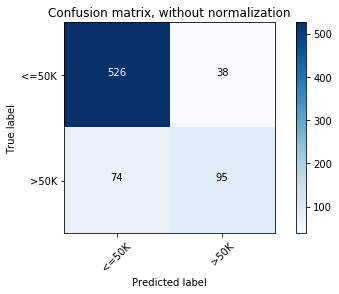

Normalized confusion matrix
[[0.93 0.07]
 [0.44 0.56]]


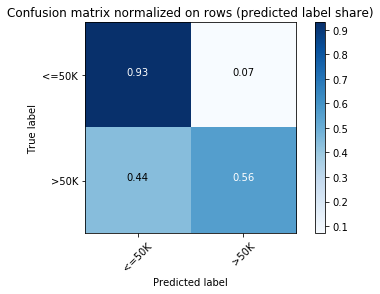

In [1]:
# for notebook plotting
%matplotlib inline 

# load what we need
import time
import timeit
import CHIRPS.structures as strcts
import CHIRPS.datasets as ds
import CHIRPS.datasets_proprietary as dsp
import CHIRPS.routines as rt

import CHIRPS.reproducible as rp
from lore import lore
from lore import test_lore as tlore
from lore import prepare_dataset as prda
from lore import neighbor_generator as ng
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier


# project_dir = '/datadisk/whiteboxing/examples'
project_dir = 'V:\\whiteboxing\\examples' # defaults to a directory "whiteboxing" in the working directory
# project_dir = 'C:\\Users\\Crutt\\Documents\\whiteboxing\\exampada'

random_state_splits = 123 # one off for splitting the data into test / train
random_state = 123 # for everything else - e.g. building a new rf with same data

# load one of the included datasets
# project_dir will default to directory name CHIRPS in the working directory if not given
# random_state will default to 123
#mydata = dsp.usoc2(random_state=random_state_splits, project_dir=project_dir)
d_constructor = ds.adult_small_samp
mydata = d_constructor(random_state=random_state_splits, project_dir=project_dir)
meta_data = mydata.get_meta()
save_path = meta_data['get_save_path']()

train_index, test_index = mydata.get_tt_split_idx(random_state=random_state_splits)
# optionally, indexes can be ommitted and will default to scikit's train_test_split method
tt = mydata.tt_split(train_index, test_index)

# build model, tuned for high accuracy
model = 'RandomForest'
# model = 'AdaBoost1'
# model = 'AdaBoost2'
# model = 'GBM'

# decide if to run the whole tuning routine again (long for Adaboost)
# RF routine has a default tuning grid, so can leave as None, or come up with some other options
tuning = {'grid' : None, 'override' : False}
if model == 'RandomForest':
    which_trees = 'majority'
    tuning.update({'grid' : None}) # defaults to n_trees [200, 400, ..., 1600]

elif model in ('AdaBoost1', 'AdaBoost2'):
    if model == 'AdaBoost1':
        # classic (and multi-class) AdaBoost
        algo = 'SAMME'
        which_trees = 'majority'
    else:
        algo = 'SAMME.R'
        which_trees = 'conf_weighted'
    max_depth = [i for i in range(1, 5)]
    tuning.update({'grid' : {'base_estimator' : [rt.DecisionTreeClassifier(max_depth=d) for d in max_depth],
                            'n_estimators': [(i + 1) * 200 for i in range(8)], 'algorithm': [algo]}})
    
else: # GBM - not fully implemented yet
    stop # ValueError

rf = rt.forest_prep(ds_container=tt,
                    meta_data=meta_data,
                    # override_tuning=True,
                    model=model,
                    tuning_grid=tuning['grid'],
                    save_path=save_path,
                    plot_cm=True, plot_cm_norm=True)

In [2]:
# lore proprietary
# path_data = 'C:\\Users\\id126493\\Documents\\GitHub\\explain_te\\lore\\datasets\\'

# dataset = prepare_german_dataset('german_credit.csv', path_data)
# dataset = prda.prepare_compass_dataset('compas-scores-two-years.csv', path_data)

# dataset = prda.prepare_adult_dataset('adult.csv', path_data)
# tlore.main(dataset=dataset, path_data=path_data, blackbox=rf, log=False)

In [ ]:
lore_dataset = rp.lore_prepare_dataset(d_constructor.__name__, mydata, meta_data)
instances, _ , instances_enc, instances_enc_matrix, labels = rp.unseen_data_prep(tt,
                                                                                n_instances=1)
rule, counterfactuals, infos = rp.lore_explain(instances.iloc[0], ds_container=tt,
                                               dataset=lore_dataset, blackbox=rf,
                                               log=False, random_state=random_state)

starting calculate features
Sat Sep  7 15:32:45 2019
starting generate neighbourhood
Sat Sep  7 15:32:45 2019


In [ ]:
print(rule)
print(counterfactuals)
print(infos)